# Phase 3 Project: Increasing the Seasonal Flu Vaccination Rate

### Soo Ho (John) Park, Timi' Adejumo

## Business Understanding
Our stockholder, Flu Heroes, is a vaccine advocacy Non-Governmental Organization that has a goal of improving access to the seasonal flu vaccine to all. The Weekly U.S. Influenza Surveillance Report from the Centers for Disease Control and Prevention (CDC) website details outcome of Public Health Laboratories flu tests carried between October, 2021 and February, 2022. Its reports reveal a positive rate of c.2% for Influenza A and Influenza B. Flu Heroes is seeking newer, innovative ways to increase the annual seasonal vaccine shot rate nationwide through advertisements and campaign efforts.

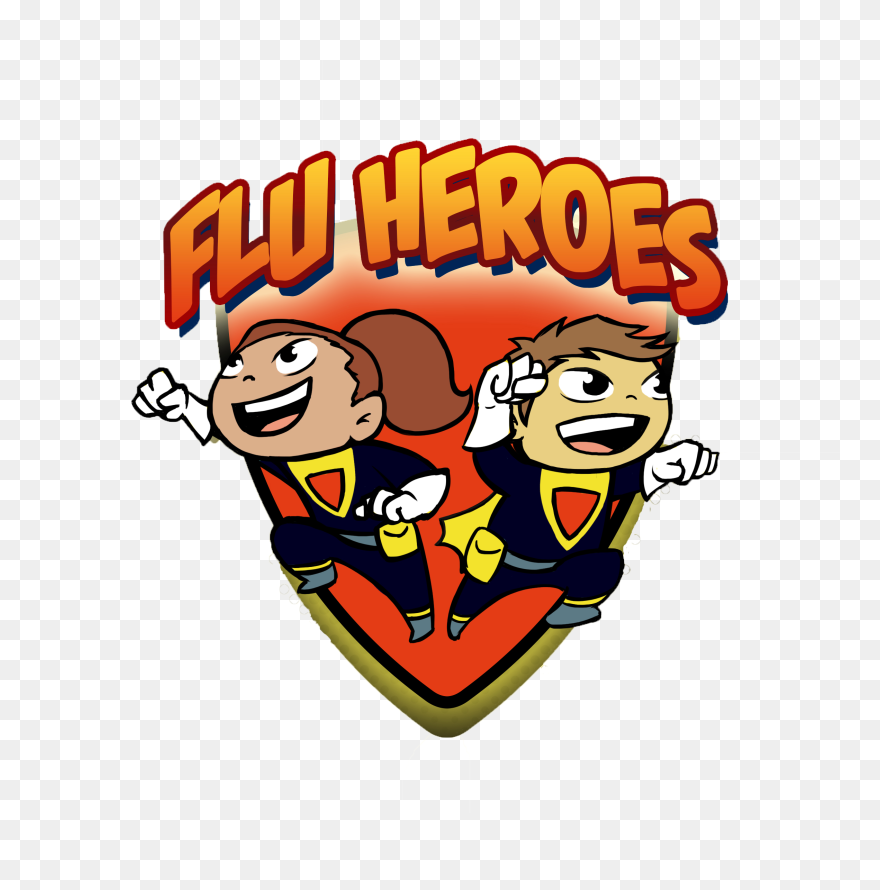

## Goal
The goal of this project is to determine what backgrounds, opinions, or health behaviors predict personal vaccination patterns of individuals. Taking it a step further, Flu Heroes will use insights gleaned from this project in allocating resources to the areas such as advertisement and campaign efforts that can increase the annual seasonal flu vaccine numbers.


## Import Libraries

As a first step, we import the Python libraries that we need.

In [ ]:
# importing Python libraries
import pandas as pd
import numpy as np
import math

from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from numpy import where

import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import tree
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_selection import SelectFromModel

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import plot_roc_curve

## Data Understanding
The next step is to load the raw datasets. We have the raw .csv files in a 'data' folder in our repository. We load the .csv files using pandas and transform to dataframes for ease of processing. The data is from the National 2009 H1N1 Flu Survey (NHFS), which was sponsored by the National Center for Immunization and Respiratory Diseases (NCIRD) and conducted jointly by NCIRD and the National Center for Health Statistics (NCHS), Centers for Disease Control and Prevention (CDC). The dataset is from a credible source with over 26,000 observations regarding seasonal flu vaccines, thus it is extremely relevant to our business question. We decided not to deeply consider demographic metrics, since categorical variables such as race had a high class imbalance, meaning it may present limitations.

In [ ]:
# Load and read the features dataset
features_df = pd.read_csv('data/training_set_features.csv')

In [ ]:
# Load and read the labels dataset
labels_df = pd.read_csv('data/training_set_labels.csv')

In [ ]:
# Read the first 5 rows of the features dataset
features_df.head()

In [ ]:
# read the first 5 rows of the labels dataset
labels_df.head()

In [ ]:
# merge the two dataframes on 'respondent_id' as the common column
df = pd.merge(labels_df,features_df,on='respondent_id')

For confirmation, read the first 5 rows of the new dataframe using the .head() function:

In [ ]:
df.head()

In [ ]:
df.shape

Our dataframe has 38 columns and 26707 rows. Using Pandas .describe() method, we can retrieve the summary statistics of the dataframe. We will also explore further to determine how many null values are in the dataframe, by column.

In [ ]:
# Obtain summary statistics
df.describe()

In [ ]:
# Number of null values for each column
df.isnull().sum()

In this project, we are looking at the seasonal flu vaccine. Since variables on H1N1 is not relevant to the issue of seasonal flu, we decided to eliminate such variables from our dataset. Moreover, columns that are contain more than 50% null values such as`employment_industry` and `health_insurance` were dropped as well. The null values in the remainder of the columns will be filled using modal imputation strategy.

In [ ]:
df = df.drop(columns=['employment_occupation','employment_industry','health_insurance','respondent_id','h1n1_vaccine',
                 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'opinion_h1n1_vacc_effective','opinion_h1n1_risk',
                 'opinion_h1n1_sick_from_vacc'])

In [ ]:
df.info()

In [ ]:
#fill in all Nan values with mode of each column
df = df.fillna(df.mode().iloc[0])

A little data exploration before modelling. We want to know: how many respondents think the seasonal flu is of any sort of health threat? Of that number, how many got the shot?

In [ ]:
# subset the union of respondents who assume there's a risk of sickness from seasonal flu AND got the shot
shot_df = df[(df['opinion_seas_risk'] > 4) & (df['seasonal_vaccine'] == 1)]

In [ ]:
# calculate the % ratio to the total number of respondents
len(shot_df) / len(df)

What is the chance that a respondent gets the shot on the physician's recommendation?


In [ ]:
doc_df = df[(df['doctor_recc_seasonal'] == 1) & (df['seasonal_vaccine'] == 0)]

In [ ]:
1 - (len(doc_df) / len(df['doctor_recc_seasonal']))

Translated in plain words, this means that for every 100 respondents who received a physician's recommendation, 92 got the shot

Following modal imputation, we have taken care of the null values. To prepare the dataframe for the first model, we extract numerical columns as the logistic regression model does not work well with non-numeric values. 

In [ ]:
# selecting numeric columns
num_df = df.select_dtypes(exclude='object')

num_df.dtypes

With the null values out of the way, it is now possible to compute pairwise correlation of columns.



In [ ]:
num_df.corr()

All the features above appear to be relevant to the issue of seasonal vaccines, thus we do not want to rule them out. As we continue our modeling process, we will continue to explore which specific features, including categorical variables, are the most relevant.

For the purposes of the "Dummy" Model, we will conduct a Train Test Split.

In [ ]:
X = num_df.drop("seasonal_vaccine", axis=1)
y = num_df["seasonal_vaccine"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

# 1st Model-"Dummy" Model

Let's start with a completely "dummy" model, that will always choose the majority class. We will use the train and test split of only numeric variables for the purposes of the dummy model.

In [ ]:
dummy_model = DummyClassifier(strategy="most_frequent")

Fit the model on our data

In [ ]:
dummy_model.fit(X_train, y_train)

We should expect all predictions to be the same

In [ ]:
y_pred = dummy_model.predict(X_train)
y_pred

## Model Evaluation

For all of our models, we are using accuracy, precision, and ROC-AUC as our main metrics. Accuracy is an evaluation metric that allows you to measure the total number of predictions a model gets correct, meaning it looks at True Positives and True Negatives. This can give us a general understanding of our model.

We also decided to look closely at precision, because precision considers False Positives in its computation. For our business objectives, False Positives are the surveyees who should have received the vaccine according to our model, but in actuality did not. Minimizing those specific cases is extremely important for our model, since our business objective is to convince the non-vaccinated to get vaccinated through advertisement.

Furthermore, we will use ROC AUC as our final metric, since it tells us how much the model is capable of distinguishing between classes via the False Positive Rate and the True Positive Rate.

Now, we will conduct a cross-validation to observe how the model would do in generalizing to new data it's never seen.

In [ ]:
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
cv_results

So, the mean accuracy is a little over 53% if we always guess the majority class. For the dummy model, we simply want to understand the general effect, taking False Negatives, False Positives, True Negatives, and True Positives into consideration.

In [ ]:
precision_score(y_train, y_pred)

The precision score is 0.0. This is understandable, because all of the predictions are made up of the majority class, which is 0 in this case. The formula for the precision score is  tp / (tp + fp), so if the True Positive values are 0, then precision is bound to be 0 as well.

In [ ]:
#sourced from the classification_workflow repo
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [ ]:
dummy_model_results = ModelWithCV(
                        model=dummy_model,
                        model_name='dummy',
                        X=X_train, 
                        y=y_train)

In [ ]:
fig, ax = plt.subplots()

ax = dummy_model_results.plot_cv(ax)
plt.tight_layout();

dummy_model_results.print_cv_summary()

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

In [ ]:
confusion_matrix(y_train, dummy_model.predict(X_train))

This confusion matrix is very lopsided. A confusion matrix summarizes the number of correct and incorrect predictions with count values and broken down by each class. The confusion matrix consists of only false positives and false negative, which means that all predictions were 0. This makes intuitive sense, since a dummy model returns predictions of 0s.

In [ ]:
plot_roc_curve(dummy_model, X_train, y_train);

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. The Area Under the ROC probability curve represents the degree or measure of separability. In other words, it informs how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is predicting 0's from 1's. Since this is a dummy model, which returns the majority class as all of its predictions, the AUC is at 0.50.

# 2nd Model - Logistic Regression

Let's use a logistic regression and compare its performance. Again, we will use the train and test split of only numeric variables for the purposes of the dummy model.

In [ ]:
simple_logreg_model = LogisticRegression(random_state=2021, penalty='none')

In [ ]:
simple_logreg_model.fit(X_train, y_train)

Look at the predictions:

In [ ]:
y_pred = simple_logreg_model.predict(X_train)
y_pred

Unlike the dummy model where it only consisted of 0 for predictions, there is more variation in the logistic regression model.

## Model Evaluation, Part 2

In [ ]:
cv_results = cross_val_score(simple_logreg_model, X_train, y_train, cv=5)
cv_results.mean()

So, the mean accuracy is approximately 75.7%, which is significantly higher than 53% for the dummy model.

In [ ]:
precision_score(y_train, y_pred)

The precision score is 0.75, which is a significant improvement from the dummy model's 0 precision score.

In [ ]:
simple_logreg_results = ModelWithCV(
                        model=simple_logreg_model,
                        model_name='simple_logreg',
                        X=X_train, 
                        y=y_train
)

In [ ]:
# Saving variable for convenience
model_results = simple_logreg_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

The accuracy of this logistic regression model is considerably better than the dummy model, since this one considers actual information from the features instead of always guessing the majority class.

In [ ]:
confusion_matrix(y_train, simple_logreg_model.predict(X_train))

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Numeric Features Only")

plot_confusion_matrix(simple_logreg_model, X_train, y_train, ax=ax, cmap="plasma");

In this new confusion matrix, we see false positives and true positives. It is less lopsided than the dummy model.

In [ ]:
plot_roc_curve(simple_logreg_model, X_train, y_train);

This model is doing better than the dummy model, since the AUC is at 0.83. A high AUC suggests that the model can better discriminate between 0s and 1s, meaning that it can make more accurate predictions.

## Returning to Data Preparation - Re-splitting Train and Test

For our dummy model and first logistical regression model, we only utilized the dataframe containing numerical variables. Now, we will conduct a new train and test split to incorporate categorical variables as well.

In [ ]:
X = df.drop(columns='seasonal_vaccine')
y = df['seasonal_vaccine']

In [ ]:
X

In [ ]:
col = ['behavioral_antiviral_meds','behavioral_avoidance',
       'behavioral_face_mask','behavioral_wash_hands','behavioral_large_gatherings',
       'behavioral_outside_home','behavioral_touch_face','doctor_recc_seasonal',
       'chronic_med_condition','child_under_6_months','health_worker','opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc','household_adults','household_children',
       'x0_35 - 44 Years', 'x0_45 - 54 Years','x0_55 - 64 Years','x0_65+ Years',
       'x1_< 12 Years','x1_College Graduate','x1_Some College','x2_Hispanic','x2_Other or Multiple',
       'x2_White', 'x3_Male', 'x4_> $75,000', 'x4_Below Poverty', 'x5_Not Married', 'x6_Rent', 
       'x7_Not in Labor Force', 'x7_Unemployed', 'x8_bhuqouqj', 'x8_dqpwygqj','x8_fpwskwrf', 'x8_kbazzjca',
       'x8_lrircsnp','x8_lzgpxyit','x8_mlyzmhmf','x8_oxchjgsf', 'x8_qufhixun','x9_MSA, Principle City', 'x9_Non-MSA']

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## One Hot Encoding: Categorical Variables

To codify categorical variables into numerical values, especially for multiclass variables, we will use One Hot Encoding.

In [ ]:
X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(drop='first',sparse=False)

dums = ohe.fit_transform(X_train_cat)
dums_df = pd.DataFrame(dums, columns=ohe.get_feature_names(), index=X_train_cat.index)

## Standard Scaler: Numerical Variables

To normalize the data, we will utilize StandardScaler, which resizes the distribution values so that the mean of the observed values is 0 and the standard deviation is 1. Data standardization is used to bring down all the features to a common scale without distorting the differences in the range of the values.

In [ ]:
X_train_nums = X_train.select_dtypes('float64')

ss = StandardScaler()

ss.fit(X_train_nums)
nums_df = pd.DataFrame(ss.transform(X_train_nums), index=X_train_nums.index)

# X-Train: Rejoining Numerical and Categorical Dataframes

After having transformed our numerical and categorical dataframes, we will concatenate the two into one combined dataframe as `X_train_clean`.

In [ ]:
X_train_clean = pd.concat([nums_df, dums_df], axis=1)

In [ ]:
X_train_clean.columns = col

In [ ]:
X_train_clean

# X-Test: Rejoining Numerical and Categorical Dataframes

After having transformed our numerical and categorical dataframes, we will concatenate the two into one combined dataframe as `X_test_clean`.

In [ ]:
X_test_cat = X_test.select_dtypes('object')

test_dums = ohe.transform(X_test_cat)
test_dums_df = pd.DataFrame(test_dums, columns=ohe.get_feature_names(), index=X_test_cat.index)

In [ ]:
X_test_nums = X_test.select_dtypes('float64')

test_nums = ss.transform(X_test_nums)
test_nums_df = pd.DataFrame(test_nums,
                           index=X_test_nums.index)

In [ ]:
X_test_clean = pd.concat([test_nums_df,
                 test_dums_df], axis=1)

In [ ]:
X_test_clean.columns = col

In [ ]:
X_test_clean

## 3rd Model: Logistic Regression 

With the newly 'clean' dataframes, which has been transformed using One Hot Encoding and Standard Scaler, we will apply a new logistic regression model.

In [ ]:
first_logreg_model = LogisticRegression(random_state=1, penalty='none')

In [ ]:
first_logreg_model.fit(X_train_clean, y_train)

In [ ]:
y_pred = first_logreg_model.predict(X_train_clean)

## 3rd Model Evaluation

In [ ]:
#accuracy of 3rd model
cv_logregresults = cross_val_score(first_logreg_model, X_train_clean, y_train, cv=5)

cv_logregresults.mean()

The mean accuracy of this model is slightly higher at 77.3% compared to the previous model, which has a mean accuracy of 75.7%.

In [ ]:
precision_score(y_train, y_pred)

Compared to the previous model, the precision score has slight increase from approximately 0.75 to 0.77. 

In [ ]:
plot_confusion_matrix(first_logreg_model, X_train_clean, y_train, cmap="plasma");

In [ ]:
confusion_matrix(y_train, first_logreg_model.predict(X_train_clean))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
plot_roc_curve(first_logreg_model, X_train_clean, y_train)

The AUC of the ROC curve is the highest at 0.85, compared to the previous models. This third logistic regression model appears to be the best model so far for accurate predictions with the highest accuracy, precision score, and AUC score.

# Decision Tree

We also applied a decision tree model to observe whether or not it can outperform the Logistic Regression models. Decision trees are easy to interpret and requires little to no data preprocessing. But, over-complex trees do not generalize well, causing overfitting.

In [ ]:
ct = DecisionTreeClassifier(max_depth=2, random_state=42)

ct.fit(X_train_clean, y_train)

In [ ]:
#Return the mean accuracy on the given test data and labels.
ct.score(X_test_clean, y_test)

## GridSearchCV

We used `GridSearchCV` in order to find the most optimal parameters for our model, otherwise known as model tuning. Rather than computing ourselves, this method automatically determines which hyperparameters for decision trees will yield the highest performance for the model.

In [ ]:
# Define the parameter grid
param_dict ={"max_depth":range(1,10),
             "min_samples_split":[10,50,100,500],"min_samples_leaf":[10,50,100,500]}

In [ ]:
# Initialize the grid search object with five-fold cross-validation
gs = GridSearchCV(ct, param_grid=param_dict, cv=5,verbose=1,n_jobs=-1)

In [ ]:
gs.fit(X_train_clean, y_train)

In [ ]:
#best parameters calculated by the GridSearchCV
gs.best_params_

In [ ]:
gs.best_score_

In [ ]:
gs.best_estimator_.score(X_test_clean, y_test)

In [ ]:
gs.cv_results_

In [ ]:
pd.DataFrame(gs.cv_results_)

In [ ]:
#using the best parameters calculated earlier, we create a new Decision Tree model
ct2 = DecisionTreeClassifier(max_depth=9, min_samples_leaf=100, min_samples_split=10, random_state=42)

ct2.fit(X_train_clean, y_train)

In [ ]:
y_pred = ct2.predict(X_test_clean)
y_pred

In [ ]:
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

In [ ]:
prec = precision_score(y_test, y_pred) * 100
print("Precision: {0}".format(prec))

In [ ]:
plot_confusion_matrix(ct2, X_test_clean, y_test);

For a more visual analysis of the decision tree model, you can look below.

In [ ]:
f, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(ct2, ax=ax, fontsize=10)
plt.show()

With an accuracy score of 77% and a precision score of approximately 0.74, the Decision Tree model is not terrible. But, our third logistic regression model has a slightly higher accuracy score of 77.3% and a higher precision score of 0.77. Even though both logistic regression and decision tree models are prone to overfitting, the third logistic regression model still appears to display better evaluation metrics, thus we decided it to be our final model.

# Best Feature

What are the most important features for predicting whether one would receive the seasonal vaccine? We aim to find out using the `ExtraTreesClassifier` method. This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [ ]:
X = X_train_clean
y = y_train
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='bar')
plt.title("Top 10 Feature Importance")
plt.show()

`doctor_recc_seasonal` - Seasonal flu vaccine was recommended by doctor. (binary)

`opinion_seas_vacc_effective` - Respondent's opinion about seasonal flu vaccine effectiveness

`opinion_seas_risk` - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.

It turns out that the `doctor_recc_seasonal`, `opinion_seas_vacc_effective`, and `opinion_seas_risk` are the top three most important features in determining whether someone received the seasonal vaccine. From this analysis, we recommend that Flu Hereos specifically tailor their advertisement and campaign efforts to emphasizes the aforementioned features. 

# Conclusion

We recommend that our stakeholder Flu Heroes tailor their advertisements to emphasize the fact there is a high risk of getting sick without the vaccine and that the seasonal flu vaccine has high effectiveness. Furthrmore, their campaign tactics should highlight that the seasonal flu vaccines were recommended by doctors. Since our final logistic regression model yields the highest accuracy, precision, and AUC scores, it can be used to predict whether or not a person would receive the seasonal flu vaccine based on his or her background information, opinions, and health behaviors. For further implementations, we could not only pinpoint which specific audience to target with advertisements, but also apply knowledge from other pandemics such as Covid-19, SARS, and H1N1. These new findings may augment our models, giving us the ability to better understand important features and predict vaccination rates.